In [320]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

In [321]:
def RBF(x1,x2,*,length_scale=1.0):
    return np.exp(-0.5/length_scale**2 * (x1-x2)**2)

def dRBF(x1,x2,*,length_scale=1.0):
    return -(x1-x2)/length_scale**2 * RBF(x1,x2,length_scale=length_scale)

def ddRBF(x1,x2,*,length_scale=1.0):
    return (1 - (x1-x2)**2 / length_scale**2) / length_scale**2 * RBF(x1,x2,length_scale=length_scale)

In [322]:
def func(x,*,noise=0.0):
    return np.sin(x) + noise*np.random.randn(*x.shape)

def grad_func(x,*,noise=0.0):
    return np.cos(x) + noise*np.random.randn(*x.shape)

In [323]:
bounds = np.array([0.0, np.pi])

noise = 0.1

length_scale = 1.0

num_datapoints = 5
datagrid = np.linspace(*bounds,num_datapoints)
num_derivpoints = 5
derivgrid = np.linspace(*bounds,num_derivpoints)

num_gridpoints = 101
grid = np.linspace(*bounds,num_gridpoints)

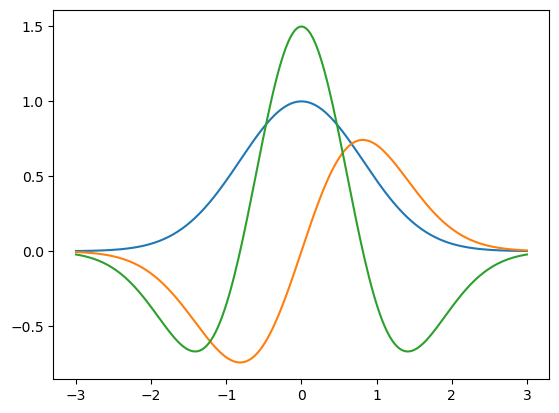

In [324]:
test = np.linspace(-3,3,201)
# x,y = np.meshgrid(test,test,sparse=True)
# plt.pcolormesh(x,y,RBF(x,y,length_scale=1/np.sqrt(1.5)))
plt.plot(test,RBF(test,0,length_scale=1/np.sqrt(1.5)))
plt.plot(test,dRBF(0,test,length_scale=1/np.sqrt(1.5)))
plt.plot(test,ddRBF(0,test,length_scale=1/np.sqrt(1.5)))

In [325]:
def mixed_covMatrix(datapoints,derivpoints,*,length_scale=1.0,alpha=1e-6):
    dim = len(derivpoints) + len(datapoints)
    dim_deriv = len(derivpoints)
    dim_data = len(datapoints)
    mat = np.zeros((dim,dim))

    xder,yder = np.meshgrid(derivpoints,derivpoints,sparse=True)
    mat[dim_data:,dim_data:] = ddRBF(xder,yder,length_scale=length_scale)

    xdata,ydata = np.meshgrid(datapoints,datapoints,sparse=True)
    mat[:dim_data,:dim_data] = RBF(xdata,ydata,length_scale=length_scale)

    xmix,ymix = np.meshgrid(datapoints,derivpoints,sparse=True)
    temp = dRBF(xmix,ymix,length_scale=length_scale)
    mat[:dim_data,dim_data:] = temp
    mat[dim_data:,:dim_data] = temp.T

    return mat + np.eye(dim)*alpha

def covMatrix(points,*,length_scale=1.0,alpha=1e-6):
    xs,ys = np.meshgrid(points,points,sparse=True)
    mat = RBF(xs,ys,length_scale=length_scale)
    
    return mat + np.eye(len(points))*alpha

def dcovMatrix(points,*,length_scale=1.0,alpha=1e-6):
    xs,ys = np.meshgrid(points,points,sparse=True)
    mat = dRBF(xs,ys,length_scale=length_scale)
    
    return mat + np.eye(len(points))*alpha

def ddcovMatrix(points,*,length_scale=1.0,alpha=1e-6):
    xs,ys = np.meshgrid(points,points,sparse=True)
    mat = ddRBF(xs,ys,length_scale=length_scale)
    
    return mat + np.eye(len(points))*alpha

In [326]:
data_values = func(datagrid,noise=noise)
derivative_values = grad_func(derivgrid,noise=noise)
# mixed_values = np.concatenate(data_values,derivative_values)

In [327]:
temp_values = solve(covMatrix(datagrid,length_scale=length_scale,alpha=noise**2),data_values)
der_cov = dcovMatrix(derivgrid,length_scale=length_scale,alpha=0.0).T
sigma_inv = np.eye(len(derivgrid)) / noise**2
data_cov = covMatrix(datagrid,length_scale=length_scale,alpha=0.0)
temp = der_cov.T@sigma_inv
combination = data_cov + temp@der_cov
der_coeffs = solve(combination,temp@derivative_values)

deriv_pred = np.array([RBF(x,derivgrid,length_scale=length_scale)@der_coeffs for x in grid])
values_pred = np.array([RBF(x,datagrid,length_scale=length_scale)@temp_values for x in grid])

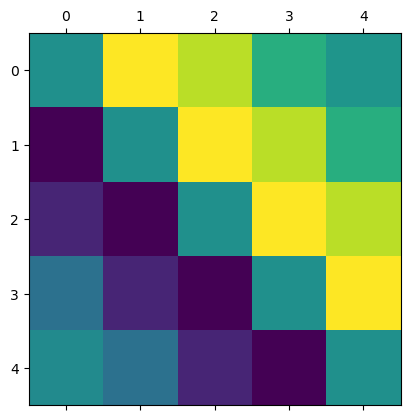

In [328]:
plt.matshow(der_cov)

In [329]:
# mixed_cov = mixed_covMatrix(datagrid,derivgrid,length_scale=length_scale,alpha=0.0)
# sigma_inv = np.eye(len(datagrid)+len(derivgrid))/noise**2
# pure_cov = covMatrix()
# temp_mixed =

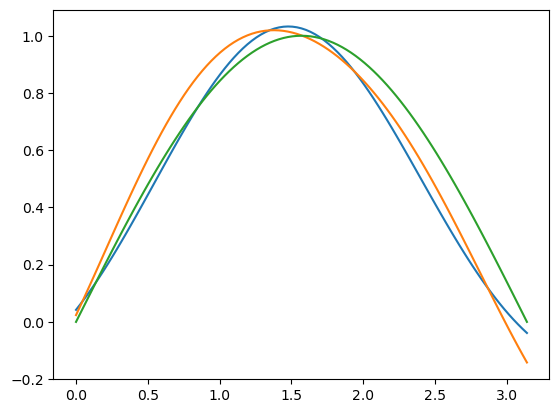

In [330]:
plt.plot(grid,values_pred)
plt.plot(grid,deriv_pred)
plt.plot(grid,func(grid))